# Why are our customers churning?

-The following notebook is the culmination of indepth analysis of churn data pulled from the company SQL server. 
The data was pulled in, cleaned and explored to find the features most likely to predict churn.
Once those features were identified, they were fed into 4 models:
- Logistic regression
- Single decision tree
- Random Forest 
- K Nearest Neighbors

The best model was selected and a presentation of the final results and recomendations can be found in the README.md of this repository. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import acquire
import wrangle

# Step 1: Aquire the data

- The data can be pulled in from a function called __get_telco_data__ which runs a SQL query of the telco_churn database. The results are comprised of features from four tables:
> - contract_types
> - internet_service_types
> - customers
> - payment_types
- The results were then converted to a pandas dataframe. The function is stored in acuire.py and imported to this notebook

In [7]:
df = acquire.get_telco_data()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.3,Yes,No,...,Yes,No,Yes,Yes,No,Yes,2,2,1,No
1,0003-MKNFE,Male,0,No,No,9,59.9,542.4,Yes,Yes,...,No,No,No,No,Yes,No,1,2,1,No
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,Yes,No,No,No,Yes,1,1,2,Yes
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,No,Yes,Yes,Yes,1,1,2,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.4,Yes,No,...,No,No,Yes,Yes,No,Yes,1,2,2,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null object
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type_

- The dataframe has 7,043 observations and 21 features with data types including object, int64 and float64.

# Step 2: Preparation

- The following changes are applied to the dataframe via the __wrangle_telco__ function store in the wrangle.py file:
> - Monthly charges column is based on the tenure column. There were several null values in the tenure column and we assumed that meant the customer was at the company for less than one month but likely would still be charged for at least one month of services. So the nulls were filled with a tenure of 1 and the value for monthly charges were set to that of other customers with a tenure of 1.
> - A boolean column of automatic payment types was added that indicates if the customer uses an automatic form of payment
> - A column of total_charges_scaled was added for the purposes of vizualization and modeling
> - Another boolean columnn of tenure_less_than_8 indicates if the customer has been a part of the company for less than 8 months

- A description of the rest of the features can be found in the data dictionary in the README.md

In [8]:
df = wrangle.wrangle_telco()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled,tenure_less_than_12,tenure_less_than_7
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.30,Yes,No,...,No,Yes,2,2,1,No,False,0.066294,True,False
1,0003-MKNFE,Male,0,No,No,9,59.9,542.40,Yes,Yes,...,Yes,No,1,2,1,No,False,0.060420,True,False
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,Yes,1,1,2,Yes,False,0.030239,True,True
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,1,1,2,Yes,False,0.140670,False,False
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.40,Yes,No,...,No,Yes,1,2,2,Yes,False,0.028687,True,True


In [9]:
# split the data into train and test for encoding, exploration and modeling
train, test = train_test_split(df, random_state=123, train_size=.86)

In [10]:
# encoding: loop w/ list of columns to encode
encoder = LabelEncoder()

encode_list = [
    'gender', 'partner', 'dependents', 'phone_service'
    , 'multiple_lines', 'online_security', 'online_backup'
    , 'device_protection', 'tech_support'
    , 'streaming_movies', 'streaming_tv', 'paperless_billing', 'churn'
    ]
               
               
               
for e in encode_list:
    train[e] = encoder.fit_transform(train[e])
    test[e] = encoder.transform(test[e])

In [11]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,total_charges_scaled,tenure_less_than_12,tenure_less_than_7
2364,3389-KTRXV,0,0,1,1,23,23.85,625.65,1,2,...,1,0,3,2,3,0,False,0.070027,False,False
6550,9300-RENDD,1,0,0,0,1,79.95,79.95,1,0,...,0,1,1,1,2,1,False,0.007056,True,True
1971,2853-CWQFQ,1,0,0,1,1,59.55,59.55,1,0,...,2,1,1,2,1,0,False,0.004702,True,True
335,0495-RVCBF,0,0,0,0,1,79.70,79.70,1,0,...,2,1,1,1,2,1,False,0.007027,True,True
5662,7979-CORPM,1,0,0,0,24,90.55,2282.55,1,2,...,0,1,1,4,2,1,True,0.261222,False,False


In [12]:
train.shape

(6056, 25)

# Step 3: Exploration

During this section, the team identified patterns in the data which may help to isolate which features were most helpful in predicting churn. 

- First we looked at tenure and total_charges_scaled at potential indicators of churn.

### First Hypothesis
- $H_0$: Total_charges and tenure have no effect on churn rate
- $H_a$: Total_charges and tenure do have an effect on churn rate
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [15]:
x1 = train[train.churn == 1].total_charges_scaled
x2 = train[train.churn == 0].total_charges_scaled
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-16.19465211561512, pvalue=8.885705458691317e-58)

In [16]:
X1 = train[train.churn == 1].tenure
X2 = train[train.churn == 0].tenure
stats.ttest_ind(X1, X2)

Ttest_indResult(statistic=-29.61955136533476, pvalue=3.565872109230304e-180)

#### Interpretation of t statistic and p value needed here

In [13]:
# How many people have churned?
train.churn.value_counts()

0    4457
1    1599
Name: churn, dtype: int64

In [14]:
# Which contract type has the highest number of people churning?
train.groupby(['churn']).contract_type_id.value_counts()

churn  contract_type_id
0      1                   1919
       3                   1421
       2                   1117
1      1                   1421
       2                    133
       3                     45
Name: contract_type_id, dtype: int64

- Of the people who have churned, the majority of them (1,421) had a month-to-month contract. Why?
- Let's add in payment types

In [21]:
train.groupby(['churn','contract_type_id']).payment_type_id.value_counts()

churn  contract_type_id  payment_type_id
0      1                 1                  740
                         2                  520
                         3                  339
                         4                  320
       2                 3                  303
                         4                  296
                         2                  274
                         1                  244
       3                 4                  491
                         3                  474
                         2                  325
                         1                  131
1      1                 1                  848
                         2                  245
                         3                  172
                         4                  156
       2                 1                   50
                         4                   36
                         3                   31
                         2                   16

- It looks like the non-automatic payment types account for the highest number of people who have churned.
- This is why we added in the column indicating if the payment type is automatic or not

In [19]:
# code to regulate the size of plots for the rest of notebook
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

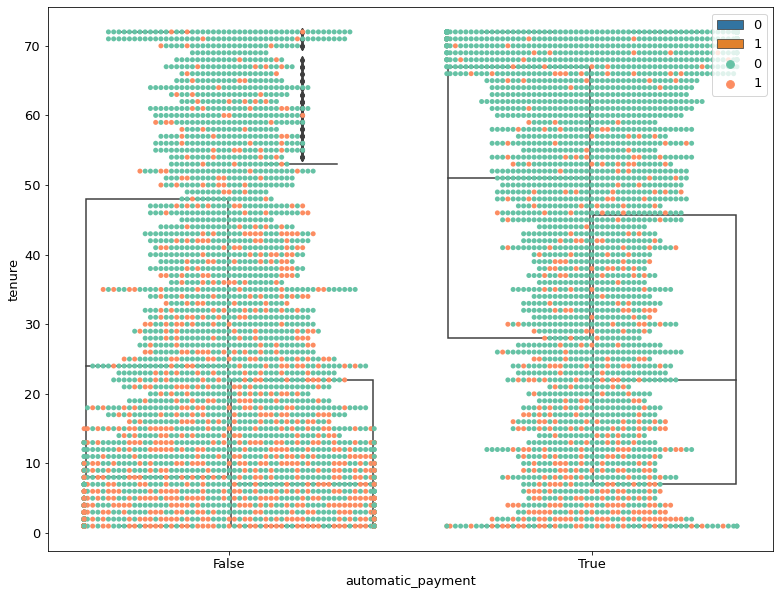

In [23]:
# At what point in thier tenure do customers tend to churn the most and what payment type do they typically use?
sns.swarmplot(x="automatic_payment", y="tenure", data=train, hue = "churn", palette="Set2")
ax = sns.boxplot(x="automatic_payment", y="tenure", data=train, hue= "churn",
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})
plt.legend(loc=1)

